In [1]:
import pickle
import os, time, itertools, imageio, pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

C:\Users\user\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\envs\tensorflow_gpu\lib\s

In [3]:
# load MNIST
mnist = input_data.read_data_sets('./MNIST_data/', one_hot=True)
train_data_num = (mnist.train.images - 0.5) / 0.5  # normalization; range: -1 ~ 1
train_label_num = mnist.train.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
# training parameters
batch_size = 100
lr = 0.0002

# variables : input
x = tf.placeholder(tf.float32, shape=(None, 784))
y = tf.placeholder(tf.float32, shape=(None, 10))
z = tf.placeholder(tf.float32, shape=(None, 100))
isTrain = tf.placeholder(dtype=tf.bool)

In [5]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'): 
    n_sample = 25
    
    sample_noise = np.random.normal(0, 1, (n_sample, 100))  #(25,100)
    sample_label = np.random.randint(0, 9, (n_sample, 1))
    sample_label = one_hot(sample_label,10)   
    
    test_images = sess.run(G_z, {z: sample_noise, y: sample_label, isTrain: False})

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid 
        j = k % size_figure_grid  
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (28, 28)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')  
    if save:
        plt.savefig(path)  
    if show:
        plt.show()       
    else:
        plt.close()      

In [6]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)  
    plt.grid(True)
    plt.tight_layout() 
    plt.title("Training Losses")
    
    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [7]:
# one hot code
def one_hot ( labels , Label_class ): 
    one_hot_label = np.array([[ int (i == int (labels[j])) for i in range (Label_class)] for j in range ( len (labels))])      
    return one_hot_label

In [8]:
# leaky_relu
def lrelu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

In [9]:
# Generator(z)
def generator(x, y, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        w_init = tf.contrib.layers.xavier_initializer()

        cat1 = tf.concat([x, y], 1)  #100(latent variable)+10(label)

        dense1 = tf.layers.dense(cat1, 128, kernel_initializer=w_init)
        relu1 = tf.nn.relu(dense1)

        dense2 = tf.layers.dense(relu1, 784, kernel_initializer=w_init)
        o = tf.nn.tanh(dense2)

        return o

In [10]:
# Discriminator(x)
def discriminator(x, y, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        w_init = tf.contrib.layers.xavier_initializer()  

        cat1 = tf.concat([x, y], 1)   # (batch_size , 784(data)+10(label) )

        dense1 = tf.layers.dense(cat1, 128, kernel_initializer=w_init)
        lrelu1 = lrelu(dense1, 0.2)

        dense2 = tf.layers.dense(lrelu1, 1, kernel_initializer=w_init)
        o = tf.nn.sigmoid(dense2)

        return o, dense2,cat1

In [11]:
# networks : generator
G_z = generator(z, y, isTrain, reuse=False)

# networks : discriminator
D_real, D_real_logits,cat1 = discriminator(x, y, isTrain)
D_fake, D_fake_logits,cat1 = discriminator(G_z, y, isTrain, reuse=True)

# loss for each network
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([batch_size, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([batch_size, 1])))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([batch_size, 1])))

# trainable variables for each network
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

# optimizer for each network
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_vars)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
# results save folder
root = 'MNIST_cGAN_results_new/'
model = 'MNIST_cGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

In [13]:
batch_size = 100
train_epoch = 1


train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

saver = tf.train.Saver(var_list = G_vars)

# open session and initialize all variables
gpu_options = tf.GPUOptions(allow_growth=True)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.global_variables_initializer())
    # training-loop
    print('training start!')
    for epoch in range(train_epoch):  #20
        G_losses = []
        D_losses = []
        for i in range(len(train_data_num) // batch_size): # 55000/100 =550
            
            # update discriminator
            real_image = train_data_num[i * batch_size:(i + 1) * batch_size]
            real_label = train_label_num[i * batch_size:(i + 1) * batch_size]

            noise_D = np.random.normal(0, 1, (batch_size, 100))

            loss_d_, _ = sess.run([D_loss, D_optim], {x: real_image, y: real_label, z: noise_D, isTrain: True})
            D_losses.append(loss_d_)
            
            # update generator
            noise_G = np.random.normal(0, 1, (batch_size, 100))
            
            noise_label = np.random.randint(0, 9, (batch_size, 1))
            noise_label = one_hot(noise_label,10)  

            loss_g_, _ = sess.run([G_loss, G_optim], {z: noise_G, x: real_image, y: noise_label, isTrain: True})
            G_losses.append(loss_g_)
            
        print('[%d/%d]  loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, np.mean(D_losses), np.mean(G_losses)))
        train_hist['D_losses'].append(np.mean(D_losses))
        train_hist['G_losses'].append(np.mean(G_losses))
        
        save_image_path = root + 'Fixed_results/' + model + str(epoch + 1) + '.png' 
        show_result((epoch + 1),show = False, save=True, path=save_image_path)  
        
        saver.save(sess, 'MNIST_cGAN_results_new/checkpoints/generator.ckpt')
        
    print("Training finish!")    
    sess.close()


training start!
[1/1]  loss_d: 0.845, loss_g: 0.978
Training finish!


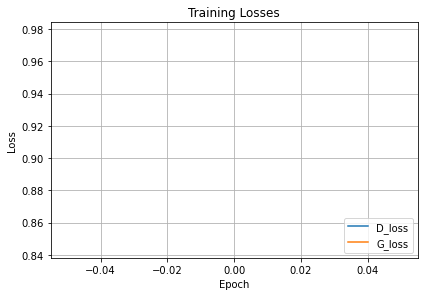

In [14]:
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)
    
save_loss_path=root + model + 'train_hist.png' 

show_train_hist(train_hist, show = True,save=True, path=save_loss_path)


In [15]:
images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name)) 
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=1)